<a href="https://colab.research.google.com/github/onurburakozdemir/FIZ437E/blob/main/HW4/HW4_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Modules

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from time import time
from matplotlib import pyplot as plt
from IPython.display import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)

Using: cuda


### Import Data

In [ ]:
dataset_path = 'drive/MyDrive/img_data'

mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)

transform = transforms.Compose([
  transforms.RandomRotation(5),
  transforms.Resize(256),
  transforms.RandomCrop(256, padding=5),

  transforms.ToTensor(),
  transforms.Normalize(mean=mean, std=std)
])

dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)

len_train = round(len(dataset)*0.8)
len_test = len(dataset) - len_train

train_dataset, test_dataset = torch.utils.data.random_split(dataset, (len_train, len_test))

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=False,
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=16,
    shuffle=False,
)

### Define CNN Model

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3), nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(16, 32, kernel_size=3), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size=3), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

        ).to(device)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(4096, 256),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(256, 3)
        ).to(device)
        
    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x


CNN_model = MyModel().to(device)
summary(CNN_model, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
              ReLU-2         [-1, 16, 254, 254]               0
            Conv2d-3         [-1, 16, 252, 252]           2,320
              ReLU-4         [-1, 16, 252, 252]               0
         MaxPool2d-5         [-1, 16, 126, 126]               0
            Conv2d-6         [-1, 32, 124, 124]           4,640
              ReLU-7         [-1, 32, 124, 124]               0
            Conv2d-8         [-1, 32, 122, 122]           9,248
              ReLU-9         [-1, 32, 122, 122]               0
        MaxPool2d-10           [-1, 32, 61, 61]               0
           Conv2d-11           [-1, 64, 59, 59]          18,496
             ReLU-12           [-1, 64, 59, 59]               0
           Conv2d-13           [-1, 64, 57, 57]          36,928
             ReLU-14           [-1, 64,

### CNN Train Function

In [ ]:
def CNN_Train(epoch, print_every=50):
    total_loss = 0
    start_time = time()
    
    accuracy = []
    
    for i, batch in enumerate(train_dataloader, 1):
        minput = batch[0].to(device) 
        target = batch[1].to(device) 
        
        moutput = CNN_model(minput) 
        
        loss = CNN_criterion(moutput, target) 
        total_loss += loss.item()

        CNN_optimizer.zero_grad() 
        loss.backward() 
        CNN_optimizer.step() 
        
        argmax = moutput.argmax(dim=1) 
        accuracy.append((target==argmax).sum().item() / target.shape[0])

        if i%print_every == 0:
            print('Epoch: [{}]/({}/{}), Train Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
                epoch, i, len(train_dataloader), loss.item(), sum(accuracy)/len(accuracy), time()-start_time 
            ))
    
    return total_loss / len(train_dataloader) , sum(accuracy)/len(accuracy)

### CNN Test Function

In [ ]:
def CNN_Test(epoch):
    total_loss = 0
    start_time = time()

    accuracy = []
    
    with torch.no_grad(): 
        for i, batch in enumerate(test_dataloader):
            minput = batch[0].to(device) 
            target = batch[1].to(device) 
            moutput = CNN_model(minput) 

            loss = CNN_criterion(moutput, target) 
            total_loss += loss.item()
            
            
            argmax = moutput.argmax(dim=1) 
            accuracy.append((target==argmax).sum().item() / target.shape[0]) 
            
    print('Epoch: [{}], Test Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
        epoch, total_loss/len(test_dataloader), sum(accuracy)/len(accuracy), time()-start_time
    ))
    return total_loss/len(test_dataloader), sum(accuracy)/len(accuracy) 

### Train Model

In [ ]:
lr = 0.0001
CNN_model = MyModel().to(device)

CNN_optimizer = optim.Adam(CNN_model.parameters(), lr=lr)
CNN_criterion = nn.CrossEntropyLoss()

In [ ]:
CNN_Test(0)

Epoch: [0], Test Loss: 1.1026, Accuracy: 0.30, Time: 204.88 sec


(1.1026473513132409, 0.30198915009041594)

In [ ]:
cnn_train_loss = []
cnn_test_loss = []
cnn_acc_train = []
cnn_acc_test = []

for epoch in range(1, 41):
    cnn_train_res = CNN_Train(epoch,79)
    cnn_train_loss.append(cnn_train_res[0])
    cnn_acc_train.append(cnn_train_res[1])

    cnn_test_res = CNN_Test(epoch)
    cnn_test_loss.append(cnn_test_res[0])
    cnn_acc_test.append(cnn_test_res[1])

    print('\n')
    
    if epoch % 10 == 0:
        torch.save(CNN_model, 'model_'+str(epoch)+'.pth')

Epoch: [1]/(79/316), Train Loss: 1.1006, Accuracy: 0.38, Time: 173.88 sec
Epoch: [1]/(158/316), Train Loss: 1.0933, Accuracy: 0.40, Time: 347.38 sec
Epoch: [1]/(237/316), Train Loss: 1.0723, Accuracy: 0.41, Time: 515.36 sec
Epoch: [1]/(316/316), Train Loss: 0.9466, Accuracy: 0.43, Time: 689.37 sec
Epoch: [1], Test Loss: 1.0083, Accuracy: 0.51, Time: 13.08 sec


Epoch: [2]/(79/316), Train Loss: 0.9122, Accuracy: 0.52, Time: 18.90 sec
Epoch: [2]/(158/316), Train Loss: 1.0455, Accuracy: 0.52, Time: 37.66 sec
Epoch: [2]/(237/316), Train Loss: 0.9866, Accuracy: 0.52, Time: 56.77 sec
Epoch: [2]/(316/316), Train Loss: 0.7485, Accuracy: 0.53, Time: 75.44 sec
Epoch: [2], Test Loss: 0.9574, Accuracy: 0.53, Time: 13.90 sec


Epoch: [3]/(79/316), Train Loss: 0.6929, Accuracy: 0.55, Time: 18.79 sec
Epoch: [3]/(158/316), Train Loss: 1.0256, Accuracy: 0.55, Time: 37.48 sec
Epoch: [3]/(237/316), Train Loss: 0.9676, Accuracy: 0.54, Time: 56.25 sec
Epoch: [3]/(316/316), Train Loss: 0.7511, Accuracy: 0.5

### Plot Losses and Accuracies

Text(0.5, 0, 'Epoch')

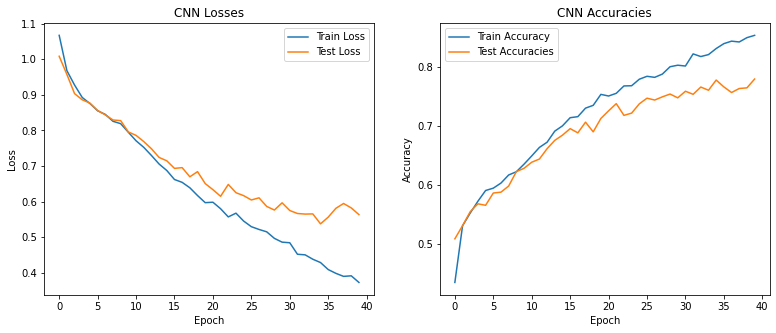

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax = ax.flatten()

ax[0].plot(cnn_train_loss, label="Train Loss")
ax[0].plot(cnn_test_loss, label="Test Loss")
ax[0].set_title("CNN Losses")
ax[0].legend(loc='best')
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")

ax[1].plot(cnn_acc_train, label="Train Accuracy")
ax[1].plot(cnn_acc_test, label="Test Accuracies")
ax[1].set_title("CNN Accuracies")
ax[1].legend(loc='best')
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
